In [2]:
import duckdb
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import plotly.express as px


# run utils.db_setup to set up duckdb database
conn = duckdb.connect('event.db')
%load_ext sql
%sql conn --alias duckdb
%config SqlMagic.displaycon=False
%config SqlMagic.autopandas=True

There's a new jupysql version available (0.10.12), you're running 0.10.10. To upgrade: pip install jupysql --upgrade
Deploy Dash apps for free on Ploomber Cloud! Learn more: https://ploomber.io/s/signup


## Schema

<img src="https://relbench.stanford.edu/img/rel-event.png" alt="schema" width="800"/>

## Tasks

### `user-attendance`

Regression -- MAE

In [4]:
%%sql train_df <<
from user_attendance_train;

In [3]:
train_df.head()

,index,timestamp,user,target
0,0,2012-10-31,18656,0.0
1,1,2012-10-31,28009,0.0
2,2,2012-10-31,10483,0.0
3,3,2012-10-31,7314,0.0
4,4,2012-10-31,37037,0.0


In [6]:
print('TRAIN\n')

print(f'{len(train_df):,} samples over {train_df.user.nunique():,} users.')
print()
print('Temporal dist of samples:')
print(train_df.timestamp.dt.strftime('%Y-%m').value_counts(normalize=True).sort_index())
print()
print('Temporal dist of users (first appearance):')
print(
    # timestamp is sorted in desc order ==> keep='last'
    train_df
    .drop_duplicates(subset='user', keep='last')
    .groupby('timestamp').user.nunique() / train_df.user.nunique()
)
print()
print('Label Distribution:')
mean = train_df.target.mean()
std = train_df.target.std()
print(f'Mean (std): {mean:,.1f} ± {std:,.1f}')
print(f'Prop zeros: {(train_df.target == 0).mean():.1%}')
print(f'Quantiles: \n{train_df.target.quantile(np.arange(0, 1.1, 0.1))}')

TRAIN

19,239 samples over 8,517 users.

Temporal dist of samples:
timestamp
2012-06    0.001195
2012-07    0.052965
2012-08    0.098758
2012-09    0.136701
2012-10    0.470814
2012-11    0.239565
Name: proportion, dtype: float64

Temporal dist of users (first appearance):
timestamp
2012-06-20    0.000235
2012-07-04    0.001879
2012-07-11    0.009393
2012-07-18    0.006692
2012-07-25    0.011154
2012-08-01    0.007632
2012-08-08    0.010567
2012-08-15    0.010450
2012-08-22    0.012915
2012-08-29    0.006692
2012-09-05    0.005049
2012-09-12    0.016203
2012-09-19    0.028296
2012-09-26    0.038276
2012-10-03    0.050839
2012-10-10    0.045791
2012-10-17    0.058471
2012-10-24    0.167078
2012-10-31    0.209463
2012-11-07    0.162616
2012-11-14    0.140308
Name: user, dtype: float64

Label Distribution:
Mean (std): 0.4 ± 0.8
Prop zeros: 72.4%
Quantiles: 
0.0     0.0
0.1     0.0
0.2     0.0
0.3     0.0
0.4     0.0
0.5     0.0
0.6     0.0
0.7     0.0
0.8     1.0
0.9     1.0
1.0    16.0
N

In [8]:
%%sql val_df <<
from user_attendance_val;

In [9]:
print('VAL\n')

print(f'{len(val_df):,} samples over {val_df.user.nunique():,} users.')
print()
print('Temporal dist of samples:')
print(val_df.timestamp.dt.strftime('%Y-%m').value_counts(normalize=True).sort_index())
print()
print('Temporal dist of users (first appearance):')
print(
    # timestamp is sorted in desc order ==> keep='last'
    val_df
    .drop_duplicates(subset='user', keep='last')
    .groupby('timestamp').user.nunique() / val_df.user.nunique()
)
print()
print(f'Users in val seen in train: {len(set(val_df.user) & set(train_df.user)):,}')
print()
print('Label Distribution:')
mean = val_df.target.mean()
std = val_df.target.std()
print(f'Mean (std): {mean:,.1f} ± {std:,.1f}')
print(f'Prop zeros: {(val_df.target == 0).mean():.1%}')
print(f'Quantiles: \n{val_df.target.quantile(np.arange(0, 1.1, 0.1))}')

VAL

2,013 samples over 2,013 users.

Temporal dist of samples:
timestamp
2012-11    1.0
Name: proportion, dtype: float64

Temporal dist of users (first appearance):
timestamp
2012-11-21    1.0
Name: user, dtype: float64

Users in val seen in train: 1,406

Label Distribution:
Mean (std): 0.3 ± 0.5
Prop zeros: 76.9%
Quantiles: 
0.0    0.0
0.1    0.0
0.2    0.0
0.3    0.0
0.4    0.0
0.5    0.0
0.6    0.0
0.7    0.0
0.8    1.0
0.9    1.0
1.0    4.0
Name: target, dtype: float64


### `user-ignore`

Binary Classification -- ROCAUC

In [11]:
%%sql train_df <<
select * from user_ignore_train;

In [12]:
train_df.head()

,index,timestamp,user,target
0,0,2012-10-24,9755,1
1,1,2012-10-24,19994,0
2,2,2012-10-24,10611,1
3,3,2012-10-24,14115,1
4,4,2012-10-24,12356,1


In [13]:
print('TRAIN\n')

print(f'{len(train_df):,} samples over {train_df.user.nunique():,} users.')
print()
print('Label Distribution:')
print(train_df.target.value_counts(normalize=True))
print()
print('Temporal dist of samples:')
print(train_df.timestamp.dt.strftime('%Y-%m').value_counts(normalize=True).sort_index())
print()
print('Temporal dist of users (first appearance):')
print(
    # timestamp is sorted in desc order ==> keep='last'
    train_df
    .drop_duplicates(subset='user', keep='last')
    .groupby('timestamp').user.nunique() / train_df.user.nunique()
)

TRAIN

19,239 samples over 8,517 users.

Label Distribution:
target
0    0.831228
1    0.168772
Name: proportion, dtype: float64

Temporal dist of samples:
timestamp
2012-06    0.001195
2012-07    0.052965
2012-08    0.098758
2012-09    0.136701
2012-10    0.470814
2012-11    0.239565
Name: proportion, dtype: float64

Temporal dist of users (first appearance):
timestamp
2012-06-20    0.000470
2012-06-27    0.000117
2012-07-04    0.000587
2012-07-11    0.005401
2012-07-18    0.006458
2012-07-25    0.009863
2012-08-01    0.008806
2012-08-08    0.007280
2012-08-15    0.012681
2012-08-22    0.018199
2012-08-29    0.011154
2012-09-05    0.008571
2012-09-12    0.011859
2012-09-19    0.034754
2012-09-26    0.038276
2012-10-03    0.049431
2012-10-10    0.047200
2012-10-17    0.069860
2012-10-24    0.153693
2012-10-31    0.215451
2012-11-07    0.167312
2012-11-14    0.122578
Name: user, dtype: float64


In [15]:
%%sql val_df <<
select * from user_ignore_val;

In [19]:
print('VAL\n')

print(f'{len(val_df):,} samples over {val_df.user.nunique():,} users.')
print()
print('Label Distribution:')
print(val_df.target.value_counts(normalize=True))
print()
print('Temporal dist of samples:')
print(val_df.timestamp.dt.strftime('%Y-%m').value_counts(normalize=True).sort_index())
print()
print(f'Users in val seen in train: {len(set(val_df.user) & set(train_df.user)):,}')
print()
print('Temporal dist of users (first appearance):')
print(
    # timestamp is sorted in desc order ==> keep='last'
    val_df
    .drop_duplicates(subset='user', keep='last')
    .groupby('timestamp').user.nunique() / val_df.user.nunique()
)

VAL

4,185 samples over 3,472 users.

Label Distribution:
target
0    0.894624
1    0.105376
Name: proportion, dtype: float64

Temporal dist of samples:
timestamp
2012-11    1.0
Name: proportion, dtype: float64

Users in val seen in train: 2,865

Temporal dist of users (first appearance):
timestamp
2012-11-14    0.506048
2012-11-21    0.493952
Name: user, dtype: float64


### `user-repeat`

In [20]:
%%sql train_df <<
select * from user_repeat_train;

In [21]:
train_df.head()

,index,timestamp,user,target
0,0,2012-10-03,35375,0
1,1,2012-10-10,35375,1
2,2,2012-10-17,35375,0
3,3,2012-10-24,35375,0
4,4,2012-08-29,1506,0


In [22]:
print('TRAIN\n')

print(f'{len(train_df):,} samples over {train_df.user.nunique():,} users.')
print()
print('Label Distribution:')
print(train_df.target.value_counts(normalize=True))
print()
print('Temporal dist of samples:')
print(train_df.timestamp.dt.strftime('%Y-%m').value_counts(normalize=True).sort_index())
print()
print('Temporal dist of users (first appearance):')
print(
    # timestamp is sorted in desc order ==> keep='last'
    train_df
    .drop_duplicates(subset='user', keep='last')
    .groupby('timestamp').user.nunique() / train_df.user.nunique()
)

TRAIN

3,842 samples over 1,388 users.

Label Distribution:
target
0    0.510151
1    0.489849
Name: proportion, dtype: float64

Temporal dist of samples:
timestamp
2012-07    0.030193
2012-08    0.135086
2012-09    0.163196
2012-10    0.416189
2012-11    0.255336
Name: proportion, dtype: float64

Temporal dist of users (first appearance):
timestamp
2012-07-25    0.001441
2012-08-01    0.005043
2012-08-08    0.004323
2012-08-15    0.008646
2012-08-22    0.007925
2012-08-29    0.007925
2012-09-05    0.006484
2012-09-12    0.014409
2012-09-19    0.012248
2012-09-26    0.027378
2012-10-03    0.026657
2012-10-10    0.043228
2012-10-17    0.036744
2012-10-24    0.108790
2012-10-31    0.128963
2012-11-07    0.208213
2012-11-14    0.351585
Name: user, dtype: float64


In [23]:
%%sql val_df <<
select * from user_repeat_val;

In [24]:
print('VAL\n')

print(f'{len(val_df):,} samples over {val_df.user.nunique():,} users.')
print()
print('Label Distribution:')
print(val_df.target.value_counts(normalize=True))
print()
print('Temporal dist of samples:')
print(val_df.timestamp.dt.strftime('%Y-%m').value_counts(normalize=True).sort_index())
print()
print(f'Users in val seen in train: {len(set(val_df.user) & set(train_df.user)):,}')
print()
print('Temporal dist of users (first appearance):')
print(
    # timestamp is sorted in desc order ==> keep='last'
    val_df
    .drop_duplicates(subset='user', keep='last')
    .groupby('timestamp').user.nunique() / val_df.user.nunique()
)

VAL

268 samples over 268 users.

Label Distribution:
target
0    0.514925
1    0.485075
Name: proportion, dtype: float64

Temporal dist of samples:
timestamp
2012-11    1.0
Name: proportion, dtype: float64

Users in val seen in train: 197

Temporal dist of users (first appearance):
timestamp
2012-11-21    1.0
Name: user, dtype: float64


## Users

In [5]:
%%sql users <<
select * from users;

In [21]:
users

,user_id,locale,birthyear,gender,joinedAt,location,timezone
0,0,en_US,1974.0,male,2012-04-13 01:06:25.740,None,-480.0
1,1,en_US,1981.0,male,2012-04-13 01:07:42.548,None,-480.0
2,2,en_US,1988.0,female,2012-04-13 01:08:36.642,None,-420.0
3,3,en_US,1980.0,male,2012-04-13 01:14:56.822,None,-420.0
4,4,en_US,1987.0,male,2012-04-13 01:25:17.690,None,-480.0
...,...,...,...,...,...,...,...
37138,37138,fa_IR,1982.0,male,2012-11-28 23:29:40.711,Tehran Iran,210.0
37139,37139,en_US,1994.0,female,2012-11-28 23:35:02.366,Los Angeles CA,-480.0
37140,37140,en_US,1984.0,female,2012-11-28 23:43:15.588,Chico California,-480.0
37141,37141,en_US,1982.0,male,2012-11-28 23:45:33.483,San Francisco California,-480.0


In [7]:
users.locale.value_counts().head(10)

locale
en_US    16405
id_ID    11755
es_LA     1938
en_GB     1701
es_ES      958
fa_IR      618
hu_HU      543
ar_AR      532
fr_FR      503
pt_BR      469
Name: count, dtype: int64

In [8]:
users.location.isna().value_counts()

location
False    31747
True      5396
Name: count, dtype: int64

In [9]:
users.timezone.value_counts(normalize=True).head(10)

timezone
 420.0    0.432502
-240.0    0.115268
-480.0    0.087621
-300.0    0.060845
 240.0    0.041498
-420.0    0.040845
 60.0     0.035239
 480.0    0.030178
 210.0    0.026150
 120.0    0.016164
Name: proportion, dtype: float64

In [10]:
users.gender.value_counts(normalize=True)

gender
male      0.605503
female    0.394497
Name: proportion, dtype: float64

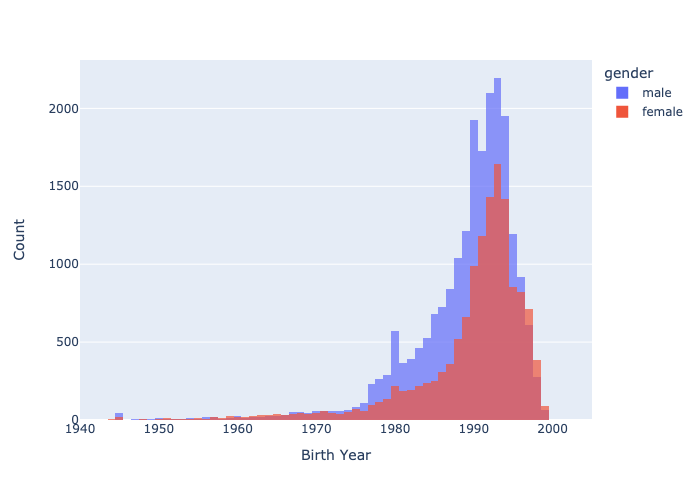

In [17]:
fig = px.histogram(users, x='birthyear', color='gender', range_x=(1940, 2005), opacity=0.7, barmode='overlay')
fig.update_layout(width=700, height=500, xaxis_title='Birth Year', yaxis_title='Count')
fig.show(renderer='png')

## User Friends

In [24]:
%%sql user_friends <<
select * from user_friends;

In [26]:
user_friends.friend.isna().mean()

0.9929098551085497

In [27]:
user_friends

,user,friend
0,8620.0,NaN
1,8620.0,NaN
2,8620.0,NaN
3,8620.0,NaN
4,8620.0,NaN
...,...,...
30386398,25479.0,NaN
30386399,25479.0,NaN
30386400,25479.0,NaN
30386401,25479.0,NaN


In [ ]:
user_friends.friend.isna().mean()

In [1]:
from relbench.datasets import get_dataset

In [3]:
ds = get_dataset('rel-event', download=True)

In [6]:
ds.get_db().table_dict['user_friends']

Loading Database object from /Users/adobles/Library/Caches/relbench/rel-event/db...
Done in 2.23 seconds.


Table(df=
           user  friend
0          8620    <NA>
1          8620    <NA>
2          8620    <NA>
3          8620    <NA>
4          8620    <NA>
...         ...     ...
30386398  25479    <NA>
30386399  25479    <NA>
30386400  25479    <NA>
30386401  25479    <NA>
30386402  25479   22052

[30386403 rows x 2 columns],
  fkey_col_to_pkey_table={'user': 'users', 'friend': 'friends'},
  pkey_col=None,
  time_col=None)

## Events

In [10]:
%%sql events <<
select * from events;

In [11]:
events

,event_id,user_id,start_time,city,state,zip,country,lat,lng,c_1,c_2,c_3,c_4,c_5,c_6,c_7,c_8,c_9,c_10,c_11,c_12,c_13,c_14,c_15,c_16,c_17,c_18,c_19,c_20,c_21,c_22,c_23,c_24,c_25,c_26,c_27,c_28,c_29,c_30,c_31,...,c_62,c_63,c_64,c_65,c_66,c_67,c_68,c_69,c_70,c_71,c_72,c_73,c_74,c_75,c_76,c_77,c_78,c_79,c_80,c_81,c_82,c_83,c_84,c_85,c_86,c_87,c_88,c_89,c_90,c_91,c_92,c_93,c_94,c_95,c_96,c_97,c_98,c_99,c_100,c_other
0,0,NaN,1912-01-01 05:59:24.003,None,None,None,None,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5
1,1,NaN,1987-11-02 01:00:00.003,None,None,None,None,NaN,NaN,10,0,6,3,5,1,1,1,3,0,2,1,2,1,2,1,5,4,0,3,5,3,0,0,3,1,1,1,1,3,0,...,0,0,1,0,1,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,4,0,1,0,0,0,0,1,0,0,102
2,2,NaN,1991-01-01 06:00:00.003,Cairo,None,None,Egypt,30.029,31.209,2,0,2,0,0,11,3,0,0,2,2,1,1,0,0,1,1,1,0,0,0,0,0,0,0,0,0,2,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,50
3,3,NaN,1999-01-01 00:00:00.001,None,None,None,None,NaN,NaN,3,1,0,0,0,0,2,0,0,0,0,0,1,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,16
4,4,NaN,1999-01-02 02:30:00.003,Arlington,TX,None,United States,32.751,-97.083,10,7,4,2,4,0,3,1,2,4,3,6,2,4,3,2,2,1,2,2,0,1,1,0,0,0,1,1,0,0,0,...,0,2,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,4,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,4,0,0,0,0,0,127
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2459806,2459806,NaN,2012-11-28 23:45:00.003,Martinez,GA,30907,United States,33.506,-82.140,2,3,3,3,0,0,5,1,1,4,1,4,1,2,1,0,0,2,1,0,0,1,3,1,1,0,1,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,2,3,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,77
2459807,2459807,NaN,2012-11-28 23:45:00.003,None,None,None,None,NaN,NaN,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13
2459808,2459808,NaN,2012-11-28 23:45:00.003,Charleston,SC,29401-3101,United States,32.781,-79.934,1,2,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,2,0,0,0,...,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,24
2459809,2459809,NaN,2012-11-28 23:45:02.003,None,None,None,None,NaN,NaN,0,0,2,1,1,0,2,1,0,0,0,0,0,1,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,...,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,26


According to docs, `c_i` columns represent the number of times the ith most common word stem appears in the name or description of the event.

In [12]:
events.user_id.isna().mean()

0.9996158241425865

In [18]:
events.country.value_counts(normalize=True, dropna=False).head(10)

country
None              0.471161
United States     0.351030
Canada            0.047824
United Kingdom    0.021953
Italy             0.015740
Australia         0.010698
Mexico            0.006052
Germany           0.005730
India             0.005317
Netherlands       0.004785
Name: proportion, dtype: float64

In [17]:
events.state.value_counts(normalize=True, dropna=False).head(10)

state
None    0.587675
CA      0.062432
NY      0.036455
ON      0.025339
TX      0.023686
FL      0.022996
IL      0.014306
PA      0.011909
MA      0.009681
WA      0.009486
Name: proportion, dtype: float64

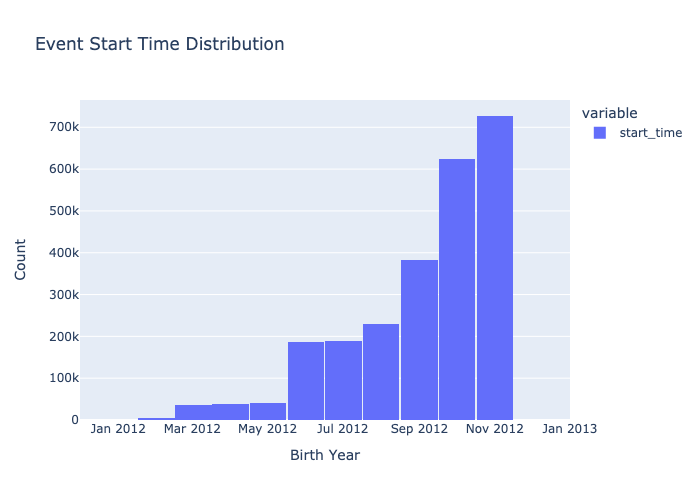

In [26]:
fig = px.histogram(events.start_time.dt.strftime('%Y-%m'), title='Event Start Time Distribution', range_x=['2011-12', '2013-01'])
fig.update_layout(width=700, height=500, xaxis_title='Birth Year', yaxis_title='Count')
fig.show(renderer='png')

In [23]:
events.start_time.describe()

count                          2459811
mean     2012-09-19 18:23:41.485703168
min         1912-01-01 05:59:24.003000
25%      2012-08-18 02:00:00.003000064
50%      2012-10-08 00:00:00.000999936
75%      2012-11-04 02:00:00.003000064
max         2012-11-28 23:59:00.003000
Name: start_time, dtype: object

## Event Attendees

In [3]:
%%sql attendees <<
select * from event_attendees;

In [4]:
attendees

,event,status,user_id,start_time
0,2346692,yes,NaN,2012-11-23 03:00:00.003
1,2346692,yes,NaN,2012-11-23 03:00:00.003
2,2346692,yes,NaN,2012-11-23 03:00:00.003
3,2346692,yes,NaN,2012-11-23 03:00:00.003
4,2346692,yes,NaN,2012-11-23 03:00:00.003
...,...,...,...,...
8429997,2329830,no,NaN,2012-11-22 05:00:00.003
8429998,2329830,no,NaN,2012-11-22 05:00:00.003
8429999,2329830,no,NaN,2012-11-22 05:00:00.003
8430000,2329830,no,NaN,2012-11-22 05:00:00.003


In [15]:
(
    attendees
    .groupby(['event', 'status'])
    .start_time
    .count()
    .reset_index()
    .groupby('status')
    .start_time
    .agg(['mean', 'std', 'min', 'max'])
)

,mean,std,min,max
status,,,,
invited,427.683332,930.781731,1,9983
maybe,23.590421,34.937384,1,915
no,26.681367,51.398858,1,1431
yes,32.174510,63.180497,1,1812


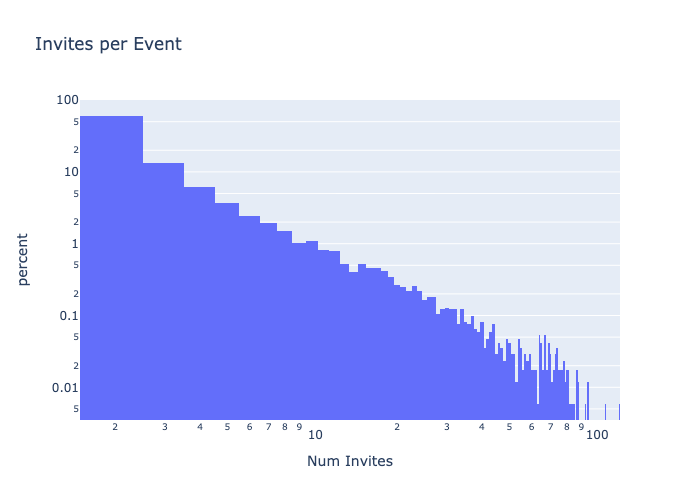

In [26]:
invites = attendees.groupby('event').user_id.count()
fig = px.histogram(
    x=(invites + 1), title='Invites per Event', histnorm='percent', labels={'x': 'Num Invites'},
    log_x=True, log_y=True
)
fig.update_layout(width=700, height=500)
fig.show(renderer='png')

## Event Interest

In [24]:
%%sql interest <<
select * from event_interest;

In [25]:
interest

,user,event,invited,timestamp,interested,not_interested
0,8949,1130067.0,0,2012-10-02 15:53:05.754,0,0
1,8949,1130381.0,0,2012-10-02 15:53:05.754,0,0
2,8949,1566551.0,0,2012-10-02 15:53:05.754,1,0
3,8949,1184649.0,0,2012-10-02 15:53:05.754,0,0
4,8949,1182052.0,0,2012-10-02 15:53:05.754,0,0
...,...,...,...,...,...,...
14973,10056,1168437.0,1,2012-10-04 10:07:33.022,1,0
14974,10056,1209485.0,0,2012-10-04 10:07:33.022,0,0
14975,10056,1147566.0,0,2012-10-04 10:07:33.022,0,0
14976,10056,1167079.0,0,2012-10-04 10:07:33.022,0,0


In [31]:
interest.groupby('event')[['invited', 'interested', 'not_interested']].sum().describe()

,invited,interested,not_interested
count,8119.000000,8119.00000,8119.000000
mean,0.073901,0.46927,0.057027
std,0.291469,2.42142,0.238713
min,0.000000,0.00000,0.000000
25%,0.000000,0.00000,0.000000
50%,0.000000,0.00000,0.000000
75%,0.000000,1.00000,0.000000
max,5.000000,118.00000,3.000000


In [30]:
interest.groupby('user')[['invited', 'interested', 'not_interested']].sum().describe()

,invited,interested,not_interested
count,1979.000000,1979.000000,1979.000000
mean,0.317837,2.039919,0.257706
std,1.071527,1.935231,2.203794
min,0.000000,1.000000,0.000000
25%,0.000000,1.000000,0.000000
50%,0.000000,1.000000,0.000000
75%,0.000000,2.000000,0.000000
max,16.000000,21.000000,49.000000
